In [ ]:
import pandas as pd
import numpy as np
import cv2
# import tifffile as tiff

# global varuables
w = h = 9

data = {'class' : ['veg', 'built', 'wat']}
dt = pd.DataFrame(data)

### Functions

In [ ]:
#
# Reads band images and index images
#
def read_img(site, _s):
    data = []

    for i in range(1, 8):
        if _s == 'B':
            filename = "input/"+ site +"/B" + str(i) + "_250_B.tif"
        else:
            filename = "input/"+ site +"/B" + str(i) + "_250.tif"
            
        img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        data.append(img)

    index = ["NDVI.tif", "NDWI.tif", "NDBI.tif"]
    for i in index:
        filename = "input/"+ site +"/" + i
        img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        data.append(img)

#     cv2.imshow("Image", data[9])
#     cv2.waitKey(0)
    
    return data

#
# Crop and Compute
#
def crop_calc(_img, _pts):
    median = []
    std = []

    # iterate over rows with iterrows()
    for index, row in _pts.iterrows():
        # print(index, row['X'], row['Y'])
        
        # move to upper right corner
        x = row['X'] - 4
        y = row['Y'] - 4
        
        crop_img = _img[y:y+h, x:x+w]
        
        #cv2.imshow("Image", crop_img)
        #cv2.waitKey(0)
        
        median.append(np.median(crop_img))
        std.append(np.std(crop_img))
            
    return [median, std]

#
# Computes IQR
#

def _iqr(q1, q3, lu, extreme):
    iqr = abs(q3 - q1)
    result = 0
    
    if lu == 0: # lower
        result = q1 - (1.5 * iqr)
        if result < extreme : # if propable is less than extreme
            result = extreme
        
    if lu == 1: # upper
        result = q3 + (1.5 * iqr)
        if result > extreme : # if propable is greater than extreme
            result = extreme
    
        
    return result
    


In [3]:
def box_plot(_stat, _img, _bndIdx):
    
    filename = 'output/veg_med_std_'
    if(_bndIdx.isdigit()):
        filename += 'b' + _bndIdx
    else:
        filename += _bndIdx
    filename += '.xlsx'        
    
    v_res = crop_calc(_img, v_pts)
    b_res = crop_calc(_img, b_pts)
    w_res = crop_calc(_img, w_pts)
    
    '''
    pd.DataFrame(v_res).to_excel(filename)
    pd.DataFrame(b_res).to_excel(filename)
    pd.DataFrame(w_res).to_excel(filename)
    '''
    
    # median = 0, std = 1
    folder =  "median/" if _stat == 0 else "std/"
    _v = v_res[_stat]
    _b = b_res[_stat]
    _w = w_res[_stat]

    res = [_v, _b, _w]
    res = pd.DataFrame(res)
    result = res.T
    # print(result.head())

    result = result.values.tolist()
    
    title = "median " if _stat == 0 else "std "
    title += str(h) + "x" + str(w) + " "
    title += "band " + _bndIdx if _bndIdx.isdigit() else _bndIdx 

    df = pd.DataFrame(result, columns=['Veg', 'Built', 'Water'])
    boxplot = df.boxplot(column=['Veg', 'Built', 'Water'])

    fig = boxplot.get_figure()
    fig.suptitle(title)
    
    # Median
    bmed = "b" + _bndIdx if _bndIdx.isdigit() else _bndIdx
    bmed += '_median';
    
    # Normal MIN
    bmin = "b" + _bndIdx if _bndIdx.isdigit() else _bndIdx
    bmin += '_min';
    # Normal MAX
    bmax = "b" + _bndIdx if _bndIdx.isdigit() else _bndIdx
    bmax += '_max';
    # Probable MIN
    bmin_p = "b" + _bndIdx if _bndIdx.isdigit() else _bndIdx
    bmin_p += '_min_p';
    # Probable MAX
    bmax_p = "b" + _bndIdx if _bndIdx.isdigit() else _bndIdx
    bmax_p += '_max_p';
    # Extreme MIN
    bmin_e = "b" + _bndIdx if _bndIdx.isdigit() else _bndIdx
    bmin_e += '_min_e';
    # Extreme MXA
    bmax_e = "b" + _bndIdx if _bndIdx.isdigit() else _bndIdx
    bmax_e += '_max_e';
    
    q1 = []
    q1.append(df['Veg'].quantile(.25))
    q1.append(df['Built'].quantile(.25))
    q1.append(df['Water'].quantile(.25))
    
    q3 = []
    q3.append(df['Veg'].quantile(.75))
    q3.append(df['Built'].quantile(.75))
    q3.append(df['Water'].quantile(.75))
    
    p_min = []
    p_min.append(_iqr(q1[0], q3[0], 0, df['Veg'].min()))
    p_min.append(_iqr(q1[1], q3[1], 0, df['Built'].min()))
    p_min.append(_iqr(q1[2], q3[2], 0, df['Water'].min()))
    
    p_max = []
    p_max.append(_iqr(q1[0], q3[0], 1, df['Veg'].max()))
    p_max.append(_iqr(q1[1], q3[1], 1, df['Built'].max()))
    p_max.append(_iqr(q1[2], q3[2], 1, df['Water'].max()))
    
    e_min = []
    e_min.append(df['Veg'].min())
    e_min.append(df['Built'].min())
    e_min.append(df['Water'].min())
    
    e_max = []
    e_max.append(df['Veg'].max())
    e_max.append(df['Built'].max())
    e_max.append(df['Water'].max())
    
    med = []
    med.append(df['Veg'].median())
    med.append(df['Built'].median())
    med.append(df['Water'].median())
    
    min_max = { bmed : med,
                bmin : q1, bmax : q3,
                bmin_p: p_min, bmax_p: p_max,
                bmin_e: e_min, bmax_e: e_max
              }
    
    dt2 = pd.DataFrame(min_max)
    return dt2


In [4]:

v_pts = pd.read_excel('input/site-b.xlsx', sheet_name = 'Vegetation')
b_pts = pd.read_excel('input/site-b.xlsx', sheet_name = 'Built-up')
w_pts = pd.read_excel('input/site-b.xlsx', sheet_name = 'Water')

i_img = read_img("Landsat8-B", 'B')

# MEDIAN

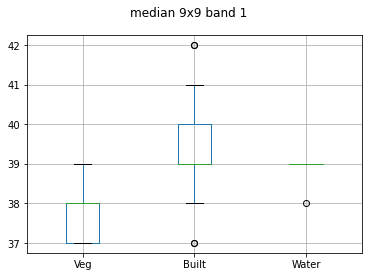

In [5]:
# median  band 1
dt2 = box_plot(0, i_img[0], "1")

In [6]:
dt = pd.concat([dt, dt2], axis = 1)
# dt.to_excel("output/median-table-b.xlsx")
dt

,class,b1_median,b1_min,b1_max,b1_min_p,b1_max_p,b1_min_e,b1_max_e
0,veg,38.0,37.0,38.0,37.0,39.0,37.0,39.0
1,built,39.0,39.0,40.0,37.5,41.5,37.0,42.0
2,wat,39.0,39.0,39.0,39.0,39.0,38.0,39.0


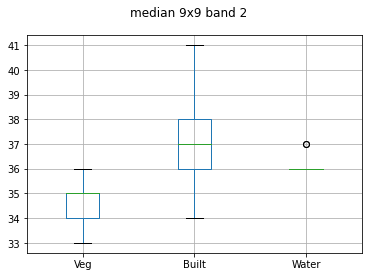

In [7]:
# median  band 2
dt2 = box_plot(0, i_img[1], "2")
dt = pd.concat([dt, dt2], axis = 1)

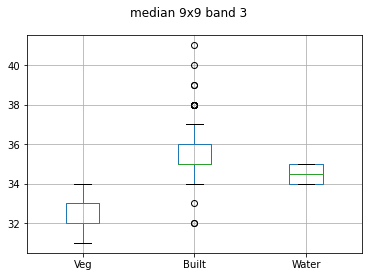

In [8]:
# median  band 3
dt2 = box_plot(0, i_img[2], "3")
dt = pd.concat([dt, dt2], axis = 1)

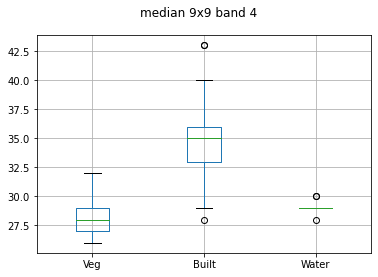

In [9]:
# median  band 4
dt2 = box_plot(0, i_img[3], "4")
dt = pd.concat([dt, dt2], axis = 1)

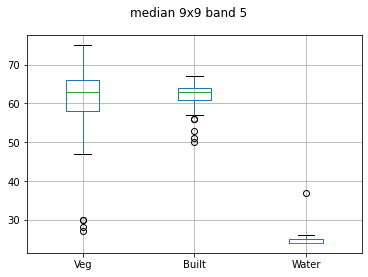

In [10]:
# median  band 5
dt2 = box_plot(0, i_img[4], "5")
dt = pd.concat([dt, dt2], axis = 1)

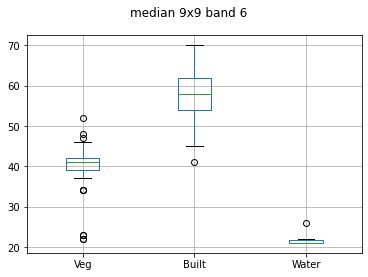

In [11]:
# median  band 6
dt2 = box_plot(0, i_img[5], "6")
dt = pd.concat([dt, dt2], axis = 1)

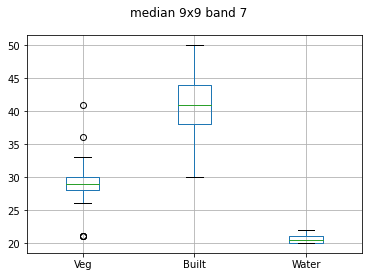

In [12]:
# median  band 7
dt2 = box_plot(0, i_img[6], "7")
dt = pd.concat([dt, dt2], axis = 1)

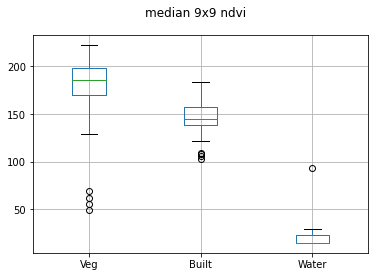

In [13]:
# median  ndvi
dt2 = box_plot(0, i_img[7], "ndvi")
dt = pd.concat([dt, dt2], axis = 1)

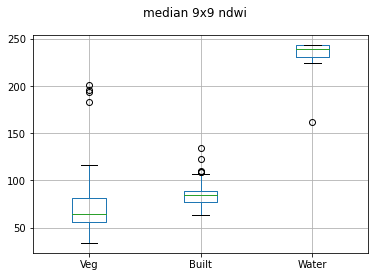

In [14]:
# median  ndwi
dt2 = box_plot(0, i_img[8], "ndwi")
dt = pd.concat([dt, dt2], axis = 1)

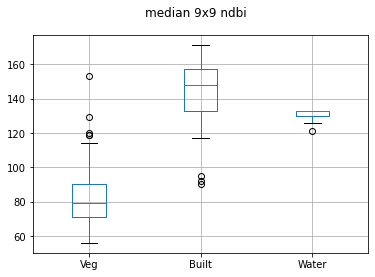

In [15]:
# median  ndbi
dt2 = box_plot(0, i_img[9], "ndbi")
dt = pd.concat([dt, dt2], axis = 1)

In [16]:
#dt.to_excel("output/medians_tr_b.xlsx")
dt

,class,b1_median,b1_min,b1_max,b1_min_p,b1_max_p,b1_min_e,b1_max_e,b2_median,b2_min,...,ndwi_max_p,ndwi_min_e,ndwi_max_e,ndbi_median,ndbi_min,ndbi_max,ndbi_min_p,ndbi_max_p,ndbi_min_e,ndbi_max_e
0,veg,38.0,37.0,38.0,37.0,39.0,37.0,39.0,35.0,34.0,...,118.5,34.0,201.0,79.0,71.00,90.0,56.000,118.5,56.0,153.0
1,built,39.0,39.0,40.0,37.5,41.5,37.0,42.0,37.0,36.0,...,107.0,63.0,134.0,148.0,133.00,157.0,97.000,171.0,90.0,171.0
2,wat,39.0,39.0,39.0,39.0,39.0,38.0,39.0,36.0,36.0,...,243.0,162.0,243.0,133.0,129.75,133.0,124.875,133.0,121.0,133.0


### Classify Reference Points based on Median Scoring

In [17]:
refb_pts = pd.read_excel('input/site-a.xlsx', sheet_name = 'test')
t_img = read_img("Landsat8-A", 'A')

refb_pts['z'] = 0

#	// TRUTH VALUES:
#	// V	(VEG, 255)
#	// M	(MAN, 128)
#	// W	(WAT, 0)


def get_score(median, _bndIdx):
    veg = built = wat = 0
    
    # Normal MIN
    bmin = "b" + _bndIdx if _bndIdx.isdigit() else _bndIdx
    bmin += '_min';
    # Normal MAX
    bmax = "b" + _bndIdx if _bndIdx.isdigit() else _bndIdx
    bmax += '_max';
    # Probable MIN
    bmin_p = "b" + _bndIdx if _bndIdx.isdigit() else _bndIdx
    bmin_p += '_min_p';
    # Probable MAX
    bmax_p = "b" + _bndIdx if _bndIdx.isdigit() else _bndIdx
    bmax_p += '_max_p';
    # Extreme MIN
    bmin_e = "b" + _bndIdx if _bndIdx.isdigit() else _bndIdx
    bmin_e += '_min_e';
    # Extreme MXA
    bmax_e = "b" + _bndIdx if _bndIdx.isdigit() else _bndIdx
    bmax_e += '_max_e';
    
    #print(bmin, dt.iloc[0][bmin], bmax, dt.iloc[0][bmax], 'median', median)
    #print(bmin, dt.iloc[1][bmin], bmax, dt.iloc[1][bmax], 'median', median)
    #print(bmin, dt.iloc[2][bmin], bmax, dt.iloc[2][bmax], 'median', median)
    
    # Vegetation
    if median >= dt.iloc[0][bmin] and median <= dt.iloc[0][bmax]:
        veg += 14
    elif median >= dt.iloc[0][bmin_p] and median <= dt.iloc[0][bmax_p]:
        veg += 4
    elif median >= dt.iloc[0][bmin_e] and median <= dt.iloc[0][bmax_e]:
        veg += 1
    else:
        veg += -14

    # Built-up
    if median >= dt.iloc[1][bmin] and median <= dt.iloc[1][bmax]:
        built += 14
    elif median >= dt.iloc[1][bmin_p] and median <= dt.iloc[1][bmax_p]:
        built += 4
    elif median >= dt.iloc[1][bmin_e] and median <= dt.iloc[1][bmax_e]:
        built += 1
    else:
        built += -14

    # Water
    if median >= dt.iloc[2][bmin] and median <= dt.iloc[2][bmax]:
        wat += 14
    elif median >= dt.iloc[2][bmin_p] and median <= dt.iloc[2][bmax_p]:
        wat += 4
    elif median >= dt.iloc[2][bmin_e] and median <= dt.iloc[2][bmax_e]:
        wat += 1
    else:
        wat += -14

    return [veg, built, wat]



# water pixel tied with vegetation
lookx = 145
looky = 184
    
for index, row in refb_pts.iterrows():
    x = row['X'] - 4
    y = row['Y'] - 4
    
    # initialize score
    _v = _b = _w = _c= 0
    
    for idx, img in enumerate(t_img, start = 1) :

        crop_img = img[y:y+h, x:x+w]
        median = np.median(crop_img)
        
        #print(x, y, median)
        
        if idx == 8:
            _bndIdx = 'ndvi'
        elif idx == 9:
            _bndIdx = 'ndwi'
        elif idx == 10:
            _bndIdx = 'ndbi'
        else:
            _bndIdx = str(idx)
 
        v_s, b_s, w_s = get_score(median, _bndIdx)

        if(x+4 == lookx and y+4 == looky):
            print('median', median)
            print('>', _bndIdx, 'pts', v_s, b_s, w_s)
            
        _v += v_s
        _b += b_s
        _w += w_s
        
    if _v > _b and _v > _w:
        _c = 255
    elif _b > _v and _b > _w:
        _c = 128
    elif _w > _v and _w > _b:
        _c = 0
    else:
        _c = -1
    
#     print(x, y, _c)
    
    if(x + 4 == lookx and y + 4 == looky):
        print(_v, _b, _w)
        
    refb_pts['z'][index] = _c


median 38.0
> 1 pts 14 4 1
median 35.0
> 2 pts 14 4 -14
median 32.0
> 3 pts 14 1 -14
median 27.0
> 4 pts 14 -14 -14
median 24.0
> 5 pts -14 -14 14
median 21.0
> 6 pts -14 -14 14
median 21.0
> 7 pts 1 -14 14
median 41.0
> ndvi pts -14 -14 1
median 231.0
> ndwi pts -14 -14 14
median 138.0
> ndbi pts 1 14 -14
2 -61 2


In [18]:
# Vegetation Class
v_v = refb_pts[(refb_pts['Class'] == 255) & (refb_pts['z'] == 255)].count()[0]
v_b = refb_pts[(refb_pts['Class'] == 255) & (refb_pts['z'] == 128)].count()[0]
v_w = refb_pts[(refb_pts['Class'] == 255) & (refb_pts['z'] == 0)].count()[0]

# Built-up Class
b_v = refb_pts[(refb_pts['Class'] == 128) & (refb_pts['z'] == 255)].count()[0]
b_b = refb_pts[(refb_pts['Class'] == 128) & (refb_pts['z'] == 128)].count()[0]
b_w = refb_pts[(refb_pts['Class'] == 128) & (refb_pts['z'] == 0)].count()[0]

# Water Class
w_v = refb_pts[(refb_pts['Class'] == 0) & (refb_pts['z'] == 255)].count()[0]
w_b = refb_pts[(refb_pts['Class'] == 0) & (refb_pts['z'] == 128)].count()[0]
w_w = refb_pts[(refb_pts['Class'] == 0) & (refb_pts['z'] == 0)].count()[0]

# other
o_v = refb_pts[(refb_pts['Class'] == 255) & (refb_pts['z'] == -1)].count()[0]
o_b = refb_pts[(refb_pts['Class'] == 128) & (refb_pts['z'] == -1)].count()[0]
o_w = refb_pts[(refb_pts['Class'] == 0) & (refb_pts['z'] == -1)].count()[0]

res = {'class' : ['veg', 'built', 'wat']}
res = pd.DataFrame(res)

res2 = pd.DataFrame({'Veg' : [v_v, b_v, w_v],
                     'Built' : [v_b, b_b, w_b],
                     'Water': [v_w, b_w, w_w],
                     'Other' : [o_v, o_b, o_w] })

res = pd.concat([res, res2], axis = 1)
res['total'] = res.sum(axis=1)

ans = res.sum(axis=0)
print(res)
res.to_excel("output/proposed-b.xlsx")

refb_pts[(refb_pts['z'] == -1)]

# Note:
# for tied score, just randomly select which class it will be classified.
# For this, I classify it as veg


   class  Veg  Built  Water  Other  total
0    veg   61      0      0      0     61
1  built    8    111      0      0    119
2    wat    4      0     15      1     20


,X,Y,Class,z
194,145,184,0,-1
